In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bell_Amundsen_Extent = pd.read_excel(filepath, sheet_name='Bell-Amundsen-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Bell_Amundsen_Extent)
fp.date_time(Bell_Amundsen_Extent)

,Extent,Date
0,1179855.894,1979-01-01
1,879585.254,1979-02-01
2,791619.096,1979-03-01
3,1254912.071,1979-04-01
4,1620142.247,1979-05-01
...,...,...
533,1556568.455,2023-06-01
534,1917507.979,2023-07-01
535,2601630.327,2023-08-01
536,2534223.780,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bell_Amundsen_Extent['Extent'] = scaler.fit_transform(Bell_Amundsen_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 9
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bell_Amundsen_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((518, 12, 1), (518,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bell_Amund_model_LT9/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 27s 340ms/step - loss: 0.1972 - root_mean_squared_error: 0.4441 - val_loss: 0.1140 - val_root_mean_squared_error: 0.3376
Epoch 2/50
53/53 [==============================] - 17s 330ms/step - loss: 0.0561 - root_mean_squared_error: 0.2368 - val_loss: 0.0561 - val_root_mean_squared_error: 0.2368
Epoch 3/50
53/53 [==============================] - 19s 359ms/step - loss: 0.0414 - root_mean_squared_error: 0.2035 - val_loss: 0.0434 - val_root_mean_squared_error: 0.2084
Epoch 4/50
53/53 [==============================] - 21s 405ms/step - loss: 0.0338 - root_mean_squared_error: 0.1840 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1844
Epoch 5/50
53/53 [==============================] - 20s 379ms/step - loss: 0.0252 - root_mean_squared_error: 0.1588 - val_loss: 0.0270 - val_root_mean_squared_error: 0.1643
Epoch 6/50
53/53 [==============================] - 2s 45ms/step - loss: 0.0195 - root_mean_squared_error: 0.1396 - val_loss: 0.0271 - 

Epoch 29/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 30/50
53/53 [==============================] - 21s 394ms/step - loss: 0.0094 - root_mean_squared_error: 0.0972 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 31/50
53/53 [==============================] - 20s 375ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1102
Epoch 32/50
53/53 [==============================] - 3s 62ms/step - loss: 0.0089 - root_mean_squared_error: 0.0945 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1116
Epoch 33/50
53/53 [==============================] - 3s 59ms/step - loss: 0.0091 - root_mean_squared_error: 0.0953 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1157
Epoch 34/50
53/53 [==============================] - 4s 76ms/step - loss: 0.0091 - root_mean_squared_error: 0.0951 - val_loss: 0.0122 - 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

12.768971153100331 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

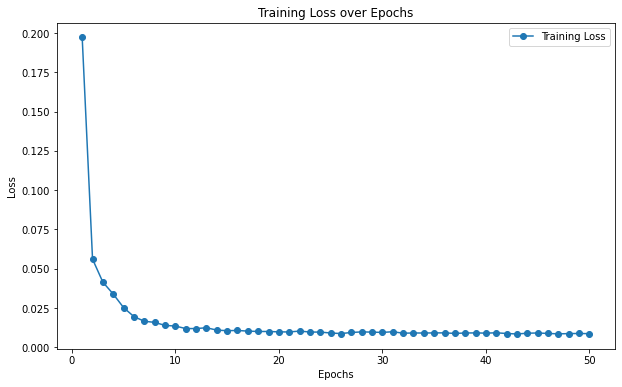

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

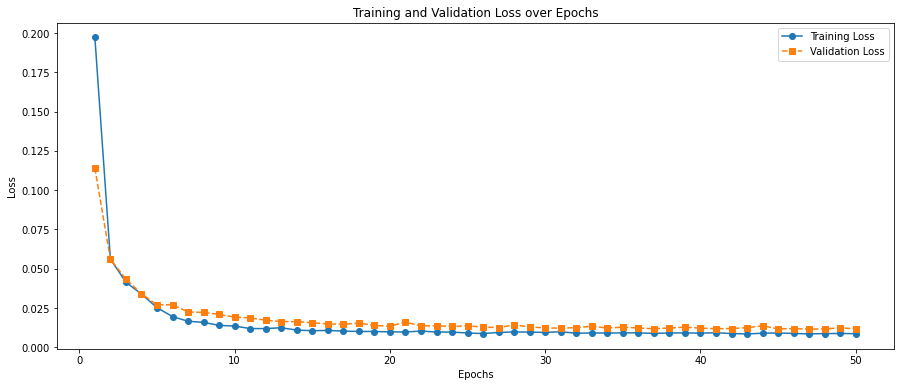

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bell_Amund_model_LT9/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 16ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.09464469204879965
MAE : 0.07805537878994506


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,6.833582e+05,752834.272
1,4.230273e+05,451914.219
2,3.385520e+05,439855.813
3,4.514525e+05,807857.307
4,1.005138e+06,1184280.145
5,1.474347e+06,1468308.405
6,1.816330e+06,1540851.607
7,2.052958e+06,1989099.836
8,2.096504e+06,2096990.761
9,1.920552e+06,2080961.032


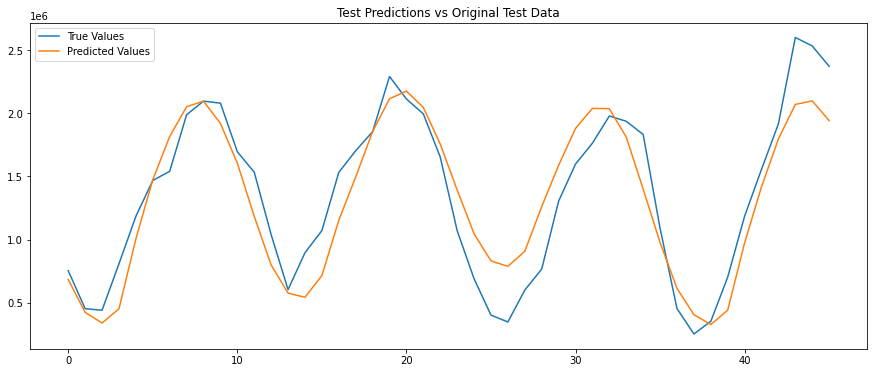

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 22ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

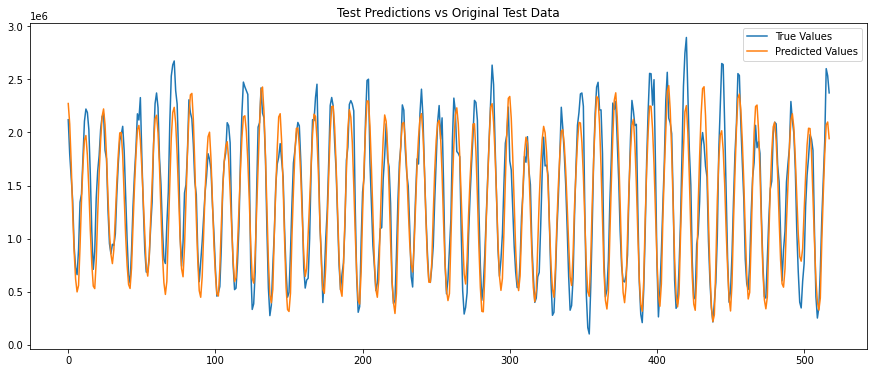

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()